In [16]:
from allennlp_models.pair_classification import *
from allennlp_models.generation import *
from allennlp_models.rc import *
from allennlp_extra.text_modifier import TextModifier
from allennlp.data.token_indexers import SingleIdTokenIndexer
from allennlp.data.data_loaders import MultiProcessDataLoader
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding
from allennlp.modules.seq2seq_encoders import LstmSeq2SeqEncoder
from allennlp.modules.matrix_attention import LinearMatrixAttention
from allennlp_extra.training import UnlearnableTrainer
from allennlp.training.learning_rate_schedulers import ReduceOnPlateauLearningRateScheduler
from allennlp.training.optimizers import AdamOptimizer
from allennlp.models import load_archive

In [3]:
# data loading
squad_reader = SquadReader(token_indexers={"tokens": SingleIdTokenIndexer(lowercase_tokens=True)}, max_instances=1000)
train_data_path = "../data/squad/squad-train-v1.1.json"
validation_data_path = "../data/squad/squad-dev-v1.1.json"
from allennlp.data.samplers import BucketBatchSampler
batch_sampler = BucketBatchSampler(batch_size=40)
train_loader = MultiProcessDataLoader(reader=squad_reader, data_path=train_data_path, batch_sampler=batch_sampler)
validation_loader = MultiProcessDataLoader(reader=squad_reader, data_path=validation_data_path,batch_sampler=batch_sampler)

In [4]:
# model
from allennlp.data import Vocabulary
instance_generator = (
            instance
            for instance in train_loader.iter_instances()
        )
vocabulary = Vocabulary.from_instances(instances=instance_generator)

generate_unlearnable_during_train = True
if generate_unlearnable_during_train:
    model = BidirectionalAttentionFlow(
        vocab=vocabulary,
        text_field_embedder=BasicTextFieldEmbedder(
            token_embedders={
                "tokens": Embedding(pretrained_file=None, embedding_dim=100, trainable=False, vocab=vocabulary)
            }),
        phrase_layer=LstmSeq2SeqEncoder(bidirectional=True, input_size=100, hidden_size=100, num_layers=1),
        matrix_attention=LinearMatrixAttention(combination="x,y,x*y", tensor_1_dim=200, tensor_2_dim=200),
        modeling_layer=LstmSeq2SeqEncoder(bidirectional=True, input_size=800, hidden_size=100, num_layers=2, dropout=0.2),
        span_end_encoder=LstmSeq2SeqEncoder(bidirectional=True, input_size=1400, hidden_size=100, num_layers=1),
        num_highway_layers= 2,
        dropout= 0.2)

else:
    model = load_archive('../models/squad/bidaf_glove/model.tar.gz').model


In [7]:
# find optimal locations to modify
task="squad"
model_name="bidaf_glove"
serialization_dir = f'outputs/{task}/{model_name}'
class_wise = False
only_where_to_modify = False
num_train_steps_per_perturbation = 10
num_epoch = 2
cuda_device = -1
text_modifier = TextModifier(
                  model=model,
                  data_loader=train_loader,

                  max_swap=1, 
                  perturb_bsz=32, 
                  class_wise=class_wise,
                  only_where_to_modify=only_where_to_modify,
                  constraints=[], 
                  input_field_name="passage",
                  serialization_dir=serialization_dir,
                  )
if only_where_to_modify:
    text_modifier.update(epoch=0, batches_in_epoch_completed=0)
else:
    parameters = [[n, p] for n, p in model.named_parameters() if p.requires_grad]
    optimizer = AdamOptimizer(model_parameters=parameters, betas=[0.9, 0.9])
    trainer = UnlearnableTrainer(
                    model=model,
                    cuda_device=cuda_device,
                    text_modifier=text_modifier,
                    data_loader=train_loader,
                    validation_data_loader=validation_loader,

                    num_train_steps_per_perturbation=num_train_steps_per_perturbation,
                    num_epochs=num_epoch,
                    grad_norm = 5.0,
                    patience=10,
                    validation_metric= "+em",
                    learning_rate_scheduler=ReduceOnPlateauLearningRateScheduler(
                        optimizer=optimizer,

                        factor=0.5,
                        mode="max",
                        patience=2
                    ),
                    optimizer=optimizer,      
                )
    train_loader.index_with(vocabulary)
    validation_loader.index_with(vocabulary)
    trainer.train()




-----Start Epoch.-----
# of training batches : 25 
# training steps per update : 10
Batch size: 40

 Batch: 1  trained.
start_acc: 0.0000, end_acc: 0.0000, span_acc: 0.0000, em: 0.0000, f1: 0.0054, batch_loss: 10.0489, loss: 10.0489 ||
start_acc: 0.0221, end_acc: 0.0125, span_acc: 0.0125, em: 0.0125, f1: 0.0214, loss: 9.4712 ||

 Batch: 2  trained.
start_acc: 0.0000, end_acc: 0.0250, span_acc: 0.0000, em: 0.0000, f1: 0.0370, batch_loss: 9.5526, loss: 9.8008 ||
start_acc: 0.0221, end_acc: 0.0135, span_acc: 0.0125, em: 0.0125, f1: 0.0226, loss: 9.4719 ||


KeyboardInterrupt: 

## TransformerQA

In [1]:
from allennlp.predictors import Predictor
import allennlp_extra
serialization_dir = '../models/squad/transformer_qa_1000unlearn_1000clean/'
transformer_model = "roberta-base"
train_data_path = "../data/squad/squad-train-v1.1.json"
validation_data_path = "../data/squad/du-dev-v1.1.json"
test_data_path = "../data/squad/du-test-v1.1.json"

predictor = Predictor.from_path(serialization_dir+'model.tar.gz', predictor_name='transformer_qa',)
squad_reader = predictor._dataset_reader
model = predictor._model

2022-01-09 18:05:20,623 - ERROR - allennlp.common.plugins - Plugin allennlp_models could not be loaded: No module named 'rouge'
2022-01-09 18:05:20,625 - INFO - allennlp.models.archival - loading archive file ../models/squad/transformer_qa_1000unlearn_1000clean/model.tar.gz
2022-01-09 18:05:20,626 - INFO - allennlp.models.archival - extracting archive file ../models/squad/transformer_qa_1000unlearn_1000clean/model.tar.gz to temp dir /tmp/tmppuuidpyy
2022-01-09 18:05:24,110 - INFO - allennlp.common.params - dataset_reader.type = perturbed_transformer_squad
2022-01-09 18:05:24,111 - INFO - allennlp.common.params - dataset_reader.max_instances = 2000
2022-01-09 18:05:24,111 - INFO - allennlp.common.params - dataset_reader.manual_distributed_sharding = False
2022-01-09 18:05:24,112 - INFO - allennlp.common.params - dataset_reader.manual_multiprocess_sharding = False
2022-01-09 18:05:24,113 - INFO - allennlp.common.params - dataset_reader.transformer_model_name = roberta-base
2022-01-09 18:

In [2]:
print(predictor._dataset_reader.max_perturbed_instances)
type(squad_reader)

1000


allennlp_extra.data.dataset_readers.perturbed_transformer_squad.PerturbedTransformerSquadReader

In [5]:
d1_unlearn_metric = None
d1_clean_metric = None
d2_clean_metric = None
idx = 0
import itertools
model.get_metrics(reset=True)
instances_iter = iter(squad_reader.read(train_data_path))
assert predictor._dataset_reader.max_perturbed_instances == 1000
while True:
    instances = list(itertools.islice(instances_iter, 20))
    if len(instances) > 0:
        output = predictor.predict_batch_instance(instances)
        if idx == 1000:
            d1_unlearn_metric = model.get_metrics(reset=True)
        idx += 20
    else: 
        break
    
d2_clean_metric = model.get_metrics(reset=True)


2022-01-09 18:09:05,628 - INFO - allennlp_extra.data.dataset_readers.perturbed_transformer_squad - Reading file at ../data/squad/squad-train-v1.1.json
2022-01-09 18:09:06,151 - INFO - allennlp_extra.data.dataset_readers.perturbed_transformer_squad - Reading the dataset
2022-01-09 18:09:06,158 - INFO - allennlp_extra.data.dataset_readers.perturbed_transformer_squad - Modify:0 with substitution product at distance_to_answer 1
2022-01-09 18:09:06,171 - INFO - allennlp_extra.data.dataset_readers.perturbed_transformer_squad - Modify:1 with substitution aristotelian at distance_to_answer 1
2022-01-09 18:09:06,183 - INFO - allennlp_extra.data.dataset_readers.perturbed_transformer_squad - Modify:2 with substitution product at distance_to_answer 1
2022-01-09 18:09:06,195 - INFO - allennlp_extra.data.dataset_readers.perturbed_transformer_squad - Modify:3 with substitution aristotelian at distance_to_answer 1
2022-01-09 18:09:06,208 - INFO - allennlp_extra.data.dataset_readers.perturbed_transform

In [8]:
predictor._dataset_reader.max_perturbed_instances = 0
predictor._dataset_reader.max_instances = 1000
idx = 0
model.get_metrics(reset=True)
instances_iter = iter(squad_reader.read(train_data_path))
while True:
    instances = list(itertools.islice(instances_iter, 20))
    if len(instances) > 0:
        output = predictor.predict_batch_instance(instances)
        idx += 20
    else:
        break

assert idx == 1000
d1_clean_metric = model.get_metrics(reset=True)
            


2022-01-09 18:26:00,577 - INFO - allennlp_extra.data.dataset_readers.perturbed_transformer_squad - Reading file at ../data/squad/squad-train-v1.1.json
2022-01-09 18:26:01,096 - INFO - allennlp_extra.data.dataset_readers.perturbed_transformer_squad - Reading the dataset
/home/xinzhel/git_repo/unlearnable-texts/allennlp_models/rc/models/utils.py:32: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  span_start_indices = best_spans // passage_length


AssertionError: 

In [9]:
print(d1_clean_metric)
print(d1_unlearn_metric)
print(d2_clean_metric)

{'start_acc': 0.7246428571428571, 'end_acc': 0.7242857142857143, 'span_acc': 0.5928571428571429, 'per_instance_em': 0.6578571428571428, 'per_instance_f1': 0.793333628892705}
{'start_acc': 0.8539215686274509, 'end_acc': 0.5843137254901961, 'span_acc': 0.5284313725490196, 'per_instance_em': 0.19607843137254902, 'per_instance_f1': 0.6816040554408777}
{'start_acc': 0.8091836734693878, 'end_acc': 0.8040816326530612, 'span_acc': 0.6948979591836735, 'per_instance_em': 0.7520408163265306, 'per_instance_f1': 0.8636887813783591}


# visualize the result

In [4]:
import json
from allennlp.data.samplers import BucketBatchSampler
from allennlp.data.data_loaders import MultiProcessDataLoader
from allennlp_models.rc.dataset_readers import SquadReader
from allennlp.data.token_indexers import SingleIdTokenIndexer

# get instances for modifications
train_loader = MultiProcessDataLoader(
    reader=SquadReader(token_indexers={"tokens": SingleIdTokenIndexer(lowercase_tokens=True)}, max_instances=1000), 
    data_path="../data/squad/squad-train-v1.1.json", 
    batch_sampler=BucketBatchSampler(batch_size=40))
instances = train_loader._instances

# modification file path
file_name = 'outputs/squad/bidaf_glove/modification_epoch0_batch20.json'

# Analyze Unleanrable Modifications

In [22]:
import json
with open( "outputs/squad/bidaf_glove/modification_epoch0_batch20_no_constraint.json", 'r') as fp:
    modifications = json.load(fp)

substitution_words = dict()
for result_dict in modifications.values():
    if result_dict['distance_to_answer'] > 1:
        print(result_dict['distance_to_answer'])
    try:
        substitution_words[result_dict['substitution_word']] += 1
    except:
        substitution_words[result_dict['substitution_word']] = 1
    
print(substitution_words)

{'product': 418, 'aristotelian': 132, 'academic': 140, 'tyra': 100, '2': 185, 'shape': 13, 'housing': 9, '52nd': 2, '.': 1}


0.975975975975976

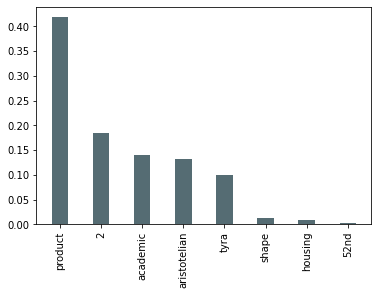

In [21]:
import pandas as pd
from matplotlib import pyplot as plt
dt_hex = "#2b4750"
r_hex = "#dc2624"
modifications = {'product': 418, 'aristotelian': 132, 'academic': 140, 'tyra': 100, '2': 185, 'shape': 13, 'housing': 9, '52nd': 2,}

modifications = dict(sorted(modifications.items(), key=lambda item: item[1], reverse=True))
label_list = list(modifications.keys())
values = list(modifications.values())
total = sum(values)
values = [v / total for v in values]
x = range(len(values))
rects1 = plt.bar(x=x, height=values, width=0.4, alpha=0.8, color=dt_hex)
plt.xticks(x, label_list, rotation=90)

sum(values[:5])

# Verify unlearnable transformer QA

In [21]:
from allennlp_extra.dataset_readers.perturbed_transformer_squad import PerturbedTransformerSquadReader
archive = load_archive('../models/squad/transformer_qa_min_min/model.tar.gz')
model = archive.model
dataset_reader = PerturbedTransformerSquadReader(
    transformer_model_name=  "roberta-base",
    length_limit = 512,
    skip_impossible_questions= True,
    max_instances = 1000,  
)
instance_generator = dataset_reader.read(file_path="../data/squad/add_unlearn_substitution_random_pos.json")

In [65]:
import numpy as np

for instance in instance_generator:
    dataset_reader.apply_token_indexers(instance)
    output = model.forward_on_instance(instance)

    start_idx = np.argmax(output["span_start_probs"])
    end_idx = np.argmax(output["span_end_probs"])
    print(instance.fields['question_with_context'].tokens[start_idx:end_idx])

[Ġproduct, ĠCatholic]
[Ġproduct, ĠCatholic]
[Ġproduct, ĠCatholic]
[Ġproduct, ĠCatholic]
[Ġproduct, Ġthree]


# Investigate well-trained transformer QA

In [66]:



from allennlp_extra.dataset_readers.perturbed_transformer_squad import PerturbedTransformerSquadReader
archive = load_archive('../models/squad/transformer_qa_sample1000_orig/model.tar.gz')
model = archive.model
dataset_reader = PerturbedTransformerSquadReader(
    transformer_model_name=  "roberta-base",
    length_limit = 512,
    skip_impossible_questions= True,
    max_instances = 1000,  
)


In [68]:
import numpy as np
instance_generator = dataset_reader.read(file_path="../data/squad/remove_surround_words.json")
for instance in instance_generator:
    dataset_reader.apply_token_indexers(instance)
    output = model.forward_on_instance(instance)

    start_idx = np.argmax(output["span_start_probs"])
    end_idx = np.argmax(output["span_end_probs"])
    print(instance.fields['question_with_context'].tokens[start_idx:end_idx])

[ĠSaint, ĠBern, ad, ette, ĠS, oub, ir]
[Ġa, Ġcopper, Ġstatue, Ġof]
[Ġthe, ĠMain]
[ĠSeptember, Ġ18]
